In [1]:
import numpy as np
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR

In [2]:
def learn_rf(X_train, y_train, X_test, y_test, num_trees):
    rfr = RFR(n_estimators=num_trees)
    rfr.fit(X_train, y_train)
    importance = rfr.feature_importances_
    
    pred_train = rfr.predict(X_train)
    pred_test = rfr.predict(X_test)
    
    estimators = rfr.estimators_
    pred_train_ind = np.zeros((len(estimators), y_train.shape[0]))
    pred_test_ind = np.zeros((len(estimators), y_test.shape[0]))
    i = 0
    for estimator in estimators:
        pred_train_ind[i] = estimator.predict(X_train)
        pred_test_ind[i] = estimator.predict(X_test)
        i += 1
    
    return importance, pred_train, pred_train_ind.T, pred_test, pred_test_ind.T


In [3]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [4]:
def learn_gbt(X_train, y_train, X_test, y_test, num_trees, learning_rate=0.2):
    gbt = GBR(n_estimators=num_trees, learning_rate=learning_rate)
    gbt.fit(X_train, y_train)
    importance = gbt.feature_importances_
    
    pred_train = gbt.predict(X_train)
    pred_test = gbt.predict(X_test)
    
    pred_train_staged = np.array(list(gbt.staged_predict(X_train)))
    pred_test_staged = np.array(list(gbt.staged_predict(X_test)))
    
    return importance, pred_train, pred_train_staged.T, pred_test, pred_test_staged.T


In [5]:
def squared_error(y_true, y_hat):
    return [(y_true[i] - y_hat[i]) ** 2 for i in xrange(len(y_true))]

In [6]:
from sklearn.linear_model import LinearRegression as LR

In [7]:
def fine_tuning(y_train, pred_train_ind, y_test, pred_test_ind):
    linear_model = LR().fit(pred_train_ind,y_train)
    pred_train = linear_model.predict(pred_train_ind)
    pred_test = linear_model.predict(pred_test_ind)
    return pred_train, pred_test

In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
data = np.loadtxt('california.dat', skiprows=1, delimiter=',')
labels = np.array(open('california.dat').readline().split(','))

data.shape
X = data[:, [range(data.shape[1] - 1)]]
y = data[:, data.shape[1] - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

X_train = X_train.reshape(X_train.shape[0::2])
X_test = X_test.reshape(X_test.shape[0::2])

In [10]:
trees = (10, 20, 30, 50, 100, 200)

rf_array = []

for tree in trees:
    rf_array.append(learn_rf(X_train, y_train, X_test, y_test, tree))

In [11]:
important_features = []
for rf in rf_array:
    # Assumed to be equal in any number of trees
    important_features = rf[0].argsort()[-3:][::-1]

In [12]:
for feature in important_features:
    print 'Important feature: {0}'.format(labels[feature])

Important feature: MedianIncome
Important feature: Longitude
Important feature: Latitude


In [13]:
train_errors_ensemble = np.zeros((len(trees), y_train.shape[0]))
test_errors_ensemble = np.zeros((len(trees), y_test.shape[0]))

train_errors_individual = []
test_errors_individual = []

for i in xrange(len(trees)):
    train_errors_ensemble[i] = squared_error(y_train, rf_array[i][1])
    test_errors_ensemble[i] = squared_error(y_test, rf_array[i][3])
    
    
    
    train_errors_ind_i = np.zeros((trees[i], y_train.shape[0]))
    test_errors_ind_i = np.zeros((trees[i], y_test.shape[0]))
    
    for j in xrange(trees[i]):
        train_errors_ind_i[j] = squared_error(y_train, rf_array[i][2].T[j])
        test_errors_ind_i[j] = squared_error(y_test, rf_array[i][4].T[j])
    
    train_errors_individual.append(train_errors_ind_i)
    test_errors_individual.append(test_errors_ind_i)


In [14]:
train_errors_ensemble_vars = np.zeros(len(trees))
test_errors_ensemble_vars = np.zeros(len(trees))
train_errors_individual_vars = np.zeros(len(trees))
test_errors_individual_vars = np.zeros(len(trees))

for i in xrange(len(trees)):
    train_errors_ensemble_vars[i] = train_errors_ensemble[i].var()
    test_errors_ensemble_vars[i] = test_errors_ensemble[i].var()
    train_errors_individual_vars[i] = train_errors_individual[i].var()
    test_errors_individual_vars[i] = test_errors_individual[i].var()


In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

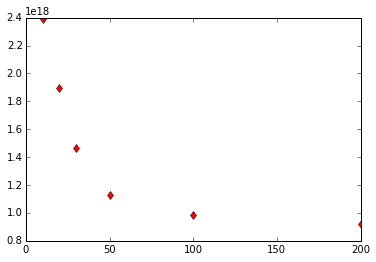

In [16]:
plt.plot(trees, train_errors_ensemble_vars, 'rd')

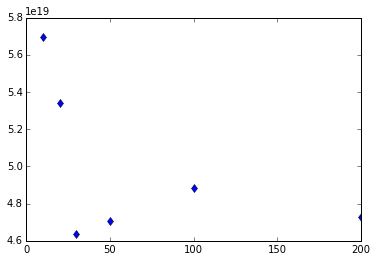

In [17]:
plt.plot(trees, test_errors_ensemble_vars, 'bd')

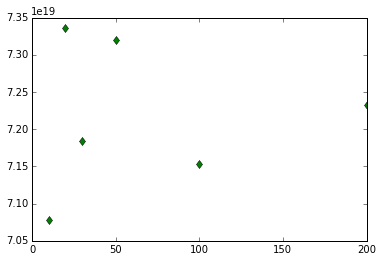

In [18]:
plt.plot(trees, train_errors_individual_vars, 'gd')

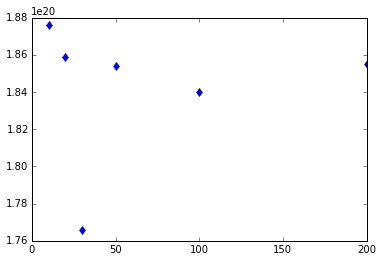

In [19]:
plt.plot(trees, test_errors_individual_vars, 'bd')

In [20]:
num_trees = 1000

gbt_res = learn_gbt(X_train, y_train, X_test, y_test, num_trees, 0.2)

In [21]:
important_features = gbt_res[0].argsort()[-3:][::-1]

In [22]:
for feature in important_features:
    print 'Important feature: {0}'.format(labels[feature])

Important feature: MedianIncome
Important feature: Longitude
Important feature: Latitude


In [23]:
gbt_errors_train = np.zeros(1000)
gbt_errors_test = np.zeros(1000)


for i in xrange(num_trees):
    gbt_errors_train[i] = np.mean(squared_error(y_train, gbt_res[2].T[i]))
    gbt_errors_test[i] = np.mean(squared_error(y_test, gbt_res[4].T[i]))


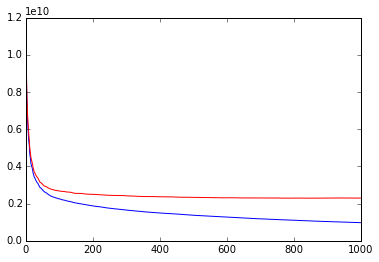

In [24]:
plt.plot(xrange(num_trees), gbt_errors_train, 'b', xrange(num_trees), gbt_errors_test, 'r', )

In [25]:
rf_trees = (10, 50, 100, 250)

rf_train_predictions = np.zeros((len(rf_trees), y_train.shape[0]))
rf_test_predictions = np.zeros((len(rf_trees), y_test.shape[0]))

rf_tuned_train_predictions = np.zeros((len(rf_trees), y_train.shape[0]))
rf_tuned_test_predictions = np.zeros((len(rf_trees), y_test.shape[0]))


for i in xrange(len(rf_trees)):
    rf = learn_rf(X_train, y_train, X_test, y_test, rf_trees[i])
    rf_train_predictions[i] = rf[1]
    rf_test_predictions[i] = rf[3]
        
    fine_tuned = fine_tuning(y_train, rf[2], y_test, rf[4])
    rf_tuned_train_predictions[i] = fine_tuned[0]
    rf_tuned_test_predictions[i] = fine_tuned[1]


In [26]:
# First element – mean, second – var
rf_train_errors = np.zeros((len(rf_trees), 2))
rf_test_errors = np.zeros((len(rf_trees), 2))

rf_tuned_train_errors = np.zeros((len(rf_trees), 2))
rf_tuned_test_errors = np.zeros((len(rf_trees), 2))

for i in xrange(len(rf_trees)):
    rf_train = squared_error(y_train, rf_train_predictions[i])
    rf_test = squared_error(y_test, rf_test_predictions[i])
    
    rf_tuned_train = squared_error(y_train, rf_tuned_train_predictions[i])
    rf_tuned_test = squared_error(y_test, rf_tuned_test_predictions[i])
    
    rf_train_errors[i][0] = np.mean(rf_train)
    rf_train_errors[i][1] = np.var(rf_train)
    
    rf_test_errors[i][0] = np.mean(rf_test)
    rf_test_errors[i][1] = np.var(rf_test)
    
    
    rf_tuned_train_errors[i][0] = np.mean(rf_tuned_train)
    rf_tuned_train_errors[i][1] = np.var(rf_tuned_train)
    
    rf_tuned_test_errors[i][0] = np.mean(rf_tuned_test)
    rf_tuned_test_errors[i][1] = np.var(rf_tuned_test)
    

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


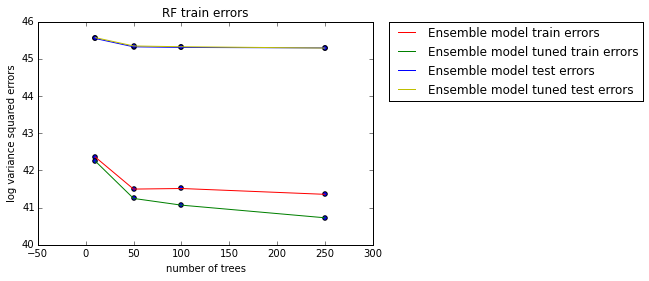

In [27]:
rf_train_errors_log = np.log(rf_train_errors[:, 1])
rf_tuned_train_errors_log = np.log(rf_tuned_train_errors[:, 1])

rf_test_errors_log = np.log(rf_test_errors[:, 1])
rf_tuned_test_errors_log = np.log(rf_tuned_test_errors[:, 1])



plt.title("RF train errors")

plt.ylabel("log variance squared errors")
plt.xlabel("number of trees")

plt.plot(rf_trees, rf_train_errors_log, 'r', label="Ensemble model train errors")
plt.scatter(rf_trees, rf_train_errors_log)

plt.plot(rf_trees, rf_tuned_train_errors_log, 'g', label="Ensemble model tuned train errors")
plt.scatter(rf_trees, rf_tuned_train_errors_log)


plt.plot(rf_trees, rf_test_errors_log, 'b', label="Ensemble model test errors")
plt.scatter(rf_trees, rf_test_errors_log)

plt.plot(rf_trees, rf_tuned_test_errors_log, 'y', label="Ensemble model tuned test errors")
plt.scatter(rf_trees, rf_tuned_test_errors_log)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

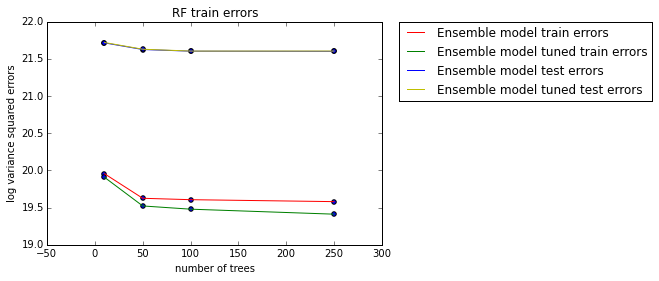

In [28]:
rf_train_errors_log = np.log(rf_train_errors[:, 0])
rf_tuned_train_errors_log = np.log(rf_tuned_train_errors[:, 0])

rf_test_errors_log = np.log(rf_test_errors[:, 0])
rf_tuned_test_errors_log = np.log(rf_tuned_test_errors[:, 0])


plt.title("RF train errors")

plt.ylabel("log variance squared errors")
plt.xlabel("number of trees")

plt.plot(rf_trees, rf_train_errors_log, 'r', label="Ensemble model train errors")
plt.scatter(rf_trees, rf_train_errors_log)

plt.plot(rf_trees, rf_tuned_train_errors_log, 'g', label="Ensemble model tuned train errors")
plt.scatter(rf_trees, rf_tuned_train_errors_log)


plt.plot(rf_trees, rf_test_errors_log, 'b', label="Ensemble model test errors")
plt.scatter(rf_trees, rf_test_errors_log)

plt.plot(rf_trees, rf_tuned_test_errors_log, 'y', label="Ensemble model tuned test errors")
plt.scatter(rf_trees, rf_tuned_test_errors_log)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [29]:
gbt_trees = (100, 500, 1000)



gbt_train_predictions = np.zeros((len(gbt_trees), y_train.shape[0]))
gbt_test_predictions = np.zeros((len(gbt_trees), y_test.shape[0]))

gbt_tuned_train_predictions = np.zeros((len(gbt_trees), y_train.shape[0]))
gbt_tuned_test_predictions = np.zeros((len(gbt_trees), y_test.shape[0]))


for i in xrange(len(gbt_trees)):
    gbt = learn_gbt(X_train, y_train, X_test, y_test, gbt_trees[i])
    gbt_train_predictions[i] = gbt[1]
    gbt_test_predictions[i] = gbt[3]
        
    fine_tuned = fine_tuning(y_train, gbt[2], y_test, gbt[4])
    gbt_tuned_train_predictions[i] = fine_tuned[0]
    gbt_tuned_test_predictions[i] = fine_tuned[1]


In [30]:
# First element – mean, second – var
gbt_train_errors = np.zeros((len(gbt_trees), 2))
gbt_test_errors = np.zeros((len(gbt_trees), 2))

gbt_tuned_train_errors = np.zeros((len(gbt_trees), 2))
gbt_tuned_test_errors = np.zeros((len(gbt_trees), 2))

for i in xrange(len(gbt_trees)):
    gbt_train = squared_error(y_train, gbt_train_predictions[i])
    gbt_test = squared_error(y_test, gbt_test_predictions[i])
    
    gbt_tuned_train = squared_error(y_train, gbt_tuned_train_predictions[i])
    gbt_tuned_test = squared_error(y_test, gbt_tuned_test_predictions[i])
    
    gbt_train_errors[i][0] = np.mean(gbt_train)
    gbt_train_errors[i][1] = np.var(gbt_train)
    
    gbt_test_errors[i][0] = np.mean(gbt_test)
    gbt_test_errors[i][1] = np.var(gbt_test)
    
    
    gbt_tuned_train_errors[i][0] = np.mean(gbt_tuned_train)
    gbt_tuned_train_errors[i][1] = np.var(gbt_tuned_train)
    
    gbt_tuned_test_errors[i][0] = np.mean(gbt_tuned_test)
    gbt_tuned_test_errors[i][1] = np.var(gbt_tuned_test)

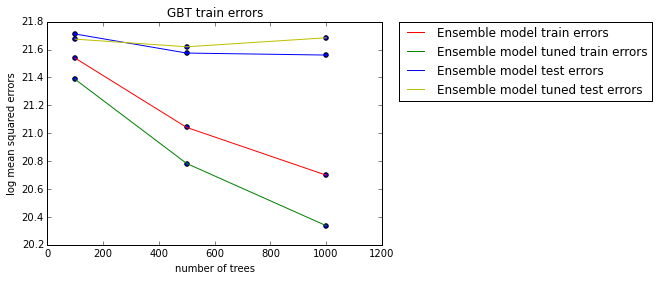

In [32]:
gbt_train_errors_log = np.log(gbt_train_errors[:, 0])
gbt_tuned_train_errors_log = np.log(gbt_tuned_train_errors[:, 0])

gbt_test_errors_log = np.log(gbt_test_errors[:, 0])
gbt_tuned_test_errors_log = np.log(gbt_tuned_test_errors[:, 0])



plt.title("GBT train errors")

plt.ylabel("log mean squared errors")
plt.xlabel("number of trees")

plt.plot(gbt_trees, gbt_train_errors_log, 'r', label="Ensemble model train errors")
plt.scatter(gbt_trees, gbt_train_errors_log)

plt.plot(gbt_trees, gbt_tuned_train_errors_log, 'g', label="Ensemble model tuned train errors")
plt.scatter(gbt_trees, gbt_tuned_train_errors_log)


plt.plot(gbt_trees, gbt_test_errors_log, 'b', label="Ensemble model test errors")
plt.scatter(gbt_trees, gbt_test_errors_log)

plt.plot(gbt_trees, gbt_tuned_test_errors_log, 'y', label="Ensemble model tuned test errors")
plt.scatter(gbt_trees, gbt_tuned_test_errors_log)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

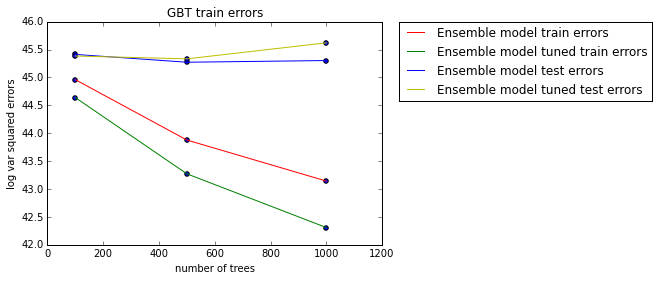

In [33]:
gbt_train_errors_log = np.log(gbt_train_errors[:, 1])
gbt_tuned_train_errors_log = np.log(gbt_tuned_train_errors[:, 1])

gbt_test_errors_log = np.log(gbt_test_errors[:, 1])
gbt_tuned_test_errors_log = np.log(gbt_tuned_test_errors[:, 1])



plt.title("GBT train errors")

plt.ylabel("log var squared errors")
plt.xlabel("number of trees")

plt.plot(gbt_trees, gbt_train_errors_log, 'r', label="Ensemble model train errors")
plt.scatter(gbt_trees, gbt_train_errors_log)

plt.plot(gbt_trees, gbt_tuned_train_errors_log, 'g', label="Ensemble model tuned train errors")
plt.scatter(gbt_trees, gbt_tuned_train_errors_log)


plt.plot(gbt_trees, gbt_test_errors_log, 'b', label="Ensemble model test errors")
plt.scatter(gbt_trees, gbt_test_errors_log)

plt.plot(gbt_trees, gbt_tuned_test_errors_log, 'y', label="Ensemble model tuned test errors")
plt.scatter(gbt_trees, gbt_tuned_test_errors_log)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()